In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [28]:
# загрузка data frame из csv:
df = pd.read_csv('phones.csv')

# выводить первые пять записей для наглядности
df.head()

,disk,os,price,year
0,64,Android,7256,2016
1,128,Android,7623,2015
2,64,Android,1916,2010
3,512,iOS,15045,2017
4,16,Android,4478,2013


In [29]:
# 1) Очистка и приведение типов
df['disk'] = df['disk'].astype(str).str.replace(r'[^0-9\.]', '', regex=True)
df['disk'] = pd.to_numeric(df['disk'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# 2) Создадим удобный признак age = текущий_год - year
current_year = pd.Timestamp.now().year   # если запустишь позже, будет актуально
df['age'] = current_year - df['year']

# 3) Удалим строки с пропусками в нужных столбцах
df = df[['disk', 'os', 'age', 'price']].dropna().reset_index(drop=True)
print(f"Строк после очистки: {len(df)}\n", df, "\n")

Строк после очистки: 100
     disk       os  age  price
0     64  Android    9   7256
1    128  Android   10   7623
2     64  Android   15   1916
3    512      iOS    8  15045
4     16  Android   12   4478
..   ...      ...  ...    ...
95   512      iOS   14   8398
96    64  Android    9   7197
97    32  Android   11   5694
98    32  Android    9   7589
99   256      iOS   11   9533

[100 rows x 4 columns] 



In [30]:
# 4) Кодирование категориальной переменной 'os'
# one-hot encoding, drop_first=True чтобы избежать коллинеарности
df_encoded = pd.get_dummies(df, columns=['os'], drop_first=True)
print("После one-hot:\n", df_encoded.head(), "\n")

# 5) Формируем X и y
feature_cols = [c for c in df_encoded.columns if c not in ('price',)]  # all except price
feature_cols.remove('price') if 'price' in feature_cols else None
feature_cols.remove('year') if 'year' in feature_cols else None  # на случай если год остался
# явный набор: disk, age и появившиеся os_* колонки
feature_cols = ['disk', 'age'] + [c for c in df_encoded.columns if c.startswith('os_')]

X = df_encoded[feature_cols].values   # (n_samples, n_features)
y = df_encoded['price'].values

print("Используемые признаки:", feature_cols, "\n")

После one-hot:
    disk  age  price  os_iOS
0    64    9   7256   False
1   128   10   7623   False
2    64   15   1916   False
3   512    8  15045    True
4    16   12   4478   False 

Используемые признаки: ['disk', 'age', 'os_iOS'] 



In [31]:
# 6) Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7) Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [32]:
# 8) Обучение модели множественной линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# 9) Оценка
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Коэффициенты (по признакам):")
for name, coef in zip(feature_cols, model.coef_):
    print(f"  {name:12s} : {coef:.4f}")
print("Intercept (b):", model.intercept_)
print(f"\nMSE: {mse:.3f}, RMSE: {rmse:.3f}, R^2: {r2:.3f}\n")

Коэффициенты (по признакам):
  disk         : 2048.9358
  age          : -2408.2708
  os_iOS       : 658.3945
Intercept (b): 8116.234759864054

MSE: 85027.696, RMSE: 291.595, R^2: 0.993



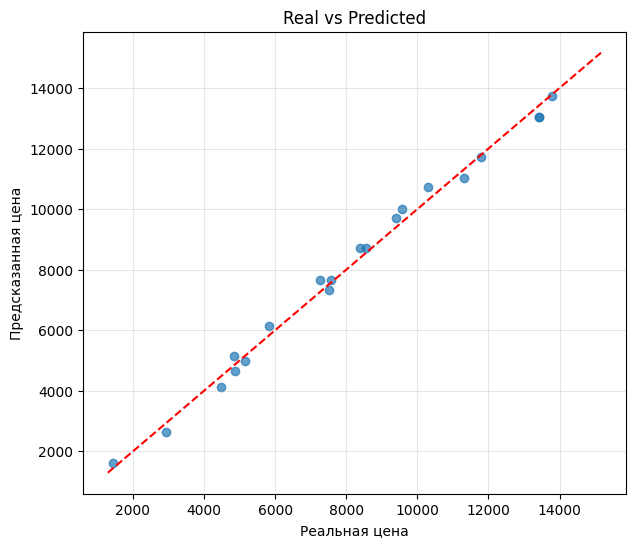

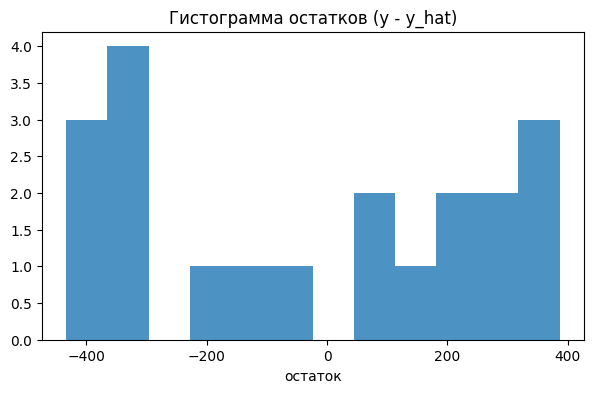

In [33]:
# 10) Визуализация: реальное vs предсказанное
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.7)
lims = [min(min(y_test), min(y_pred)) * 0.9, max(max(y_test), max(y_pred)) * 1.1]
plt.plot(lims, lims, '--', color='red')  # линия y=x
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')
plt.title('Real vs Predicted')
plt.grid(alpha=0.3)
plt.show()

# Резиды (остатки)
residuals = y_test - y_pred
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=12, alpha=0.8)
plt.title('Гистограмма остатков (y - y_hat)')
plt.xlabel('остаток')
plt.show()

In [34]:
# 11) Как предсказать для нового телефона (пример)
# новый объект: disk, os, year (или age)
new = pd.DataFrame([{'disk': 128, 'os': 'Android', 'year': 2019}])
new['disk'] = new['disk'].astype(float)
new['year'] = pd.to_numeric(new['year'], errors='coerce')
new['age'] = current_year - new['year']

# one-hot для нового: нужно иметь те же колонки, поэтому делаем get_dummies и reindex
new_enc = pd.get_dummies(new, columns=['os'], drop_first=True)
# убедимся что колонка(ы) os_* совпадают с тренировочными; добавим отсутствующие со значением 0
for col in [c for c in feature_cols if c.startswith('os_')]:
    if col not in new_enc.columns:
        new_enc[col] = 0

# оставить только нужные признаки в правильном порядке
new_X = new_enc[['disk', 'age'] + [c for c in feature_cols if c.startswith('os_')]].values

# масштабируем и предсказываем
new_X_scaled = scaler.transform(new_X)
pred_price = model.predict(new_X_scaled)
print(f"Предсказанная цена для {new.to_dict(orient='records')[0]}: {pred_price[0]:.2f}")

Предсказанная цена для {'disk': 128.0, 'os': 'Android', 'year': 2019, 'age': 6}: 11364.38
